In [1]:
from scipy.io import wavfile
sample_rate, data = wavfile.read('./baseband_433123259Hz_12-22-59_30-07-2025.wav')

good_sample_rate, good_data = wavfile.read('./hello_sad_and_happy_humans_baseband_433025236Hz_14-50-04_26-07-2025.wav')

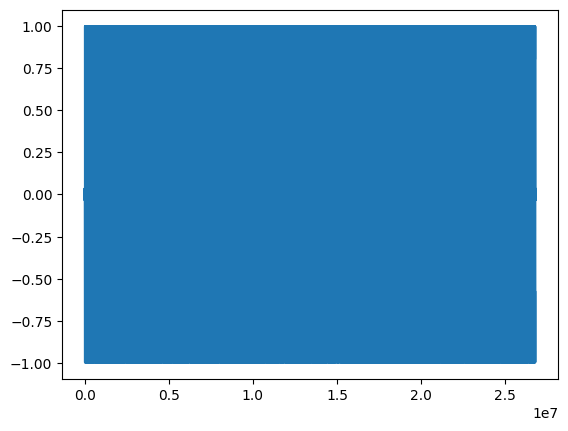

In [5]:
import matplotlib.pyplot as plt

plt.plot(good_data[:,1])
plt.show()

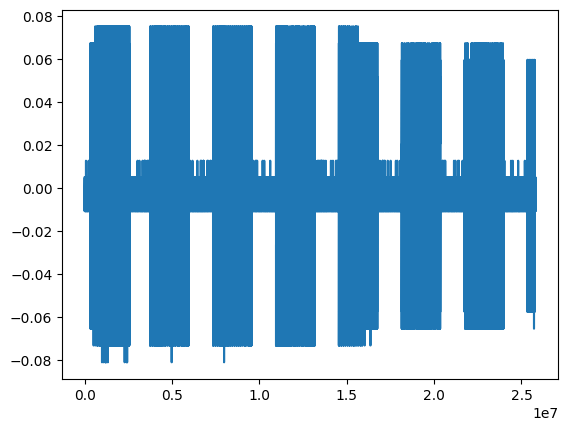

In [3]:
import matplotlib.pyplot as plt

plt.plot(data[:,1])
plt.show()

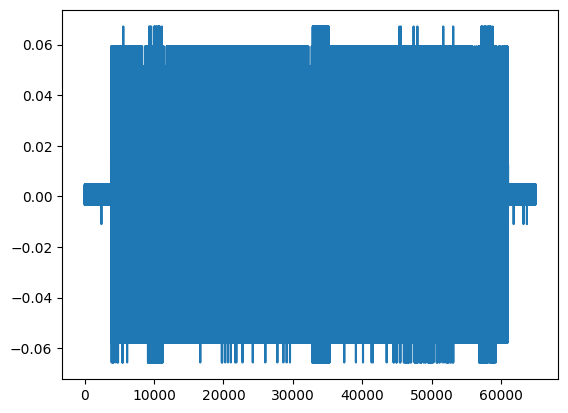

In [88]:
start_i = 335000
plt.plot(data[:,1][start_i:400000])

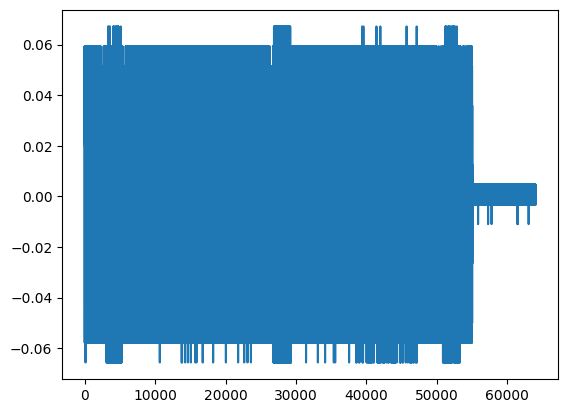

In [160]:
# start_i = 331000
plt.plot(data[:,1][start_i+start_ad:start_i + len_s])

In [147]:
def analyze_demodulated_signal_fft(demodulated_signal, sample_rate, oversampling_rate):
    """
    Performs an FFT on the demodulated signal and plots the frequency spectrum.
    
    Parameters:
    - demodulated_signal: The phase-difference signal from FSK demodulation.
    - sample_rate: The original sample rate of the SDR capture.
    - oversampling_rate: The number of samples per symbol.
    """
    
    # Calculate the FFT of the demodulated signal
    # We use np.fft.fft to get the complex frequency components
    fft_result = np.fft.fft(demodulated_signal)
    
    # Calculate the frequency axis for the plot
    # The sampling frequency of the demodulated signal is not the original
    # sample_rate, but rather the original sample_rate. We use that for scaling the frequency axis.
    n = len(demodulated_signal)
    
    # The frequency resolution is sample_rate / n. The Nyquist frequency is half the sample rate.
    fft_freqs = np.fft.fftfreq(n, d=1/sample_rate)

    # Plot the magnitude of the FFT. We only need the positive frequency side.
    # The first half of the array contains the positive frequencies.
    # We use `np.abs` to get the magnitude of the complex numbers.
    positive_freqs = fft_freqs[:n//2]
    magnitude = np.abs(fft_result[:n//2])
    
    plt.figure(figsize=(12, 6))
    plt.plot(positive_freqs, magnitude)
    plt.title('Frequency Spectrum of Demodulated FSK Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.xlim(0, 100000) # Limit the x-axis for a clearer view of the FSK tones
    plt.show()

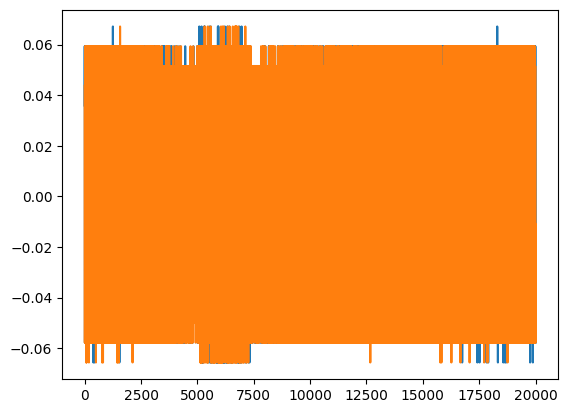

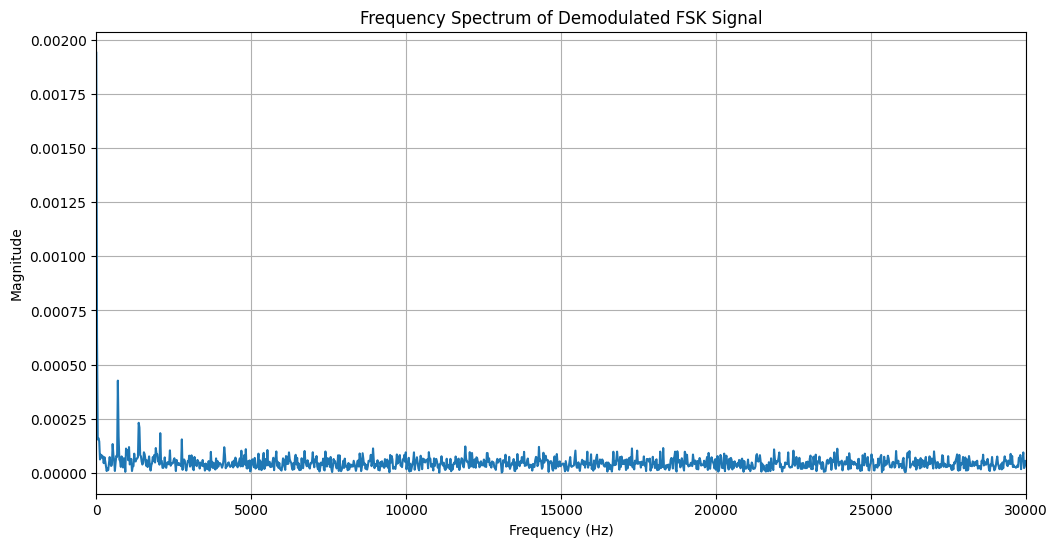

In [178]:
import numpy as np
len_s = 20000
start_i = 339000

SAMPLE_RATE = 2400000  # From your WAV file info (2.4 MHz)
SYMBOL_RATE = 9600     # From the Arduino code (9.6 kbps)
OVERSAMPLING_RATE = int(SAMPLE_RATE / SYMBOL_RATE) # Calculate the oversampling rate

I = data[:,0][start_i:start_i + len_s]
Q = data[:,1][start_i:start_i + len_s]
plt.plot(I)
plt.plot(Q)
analyze_demodulated_signal_fft(complex_signal, SAMPLE_RATE, OVERSAMPLING_RATE)


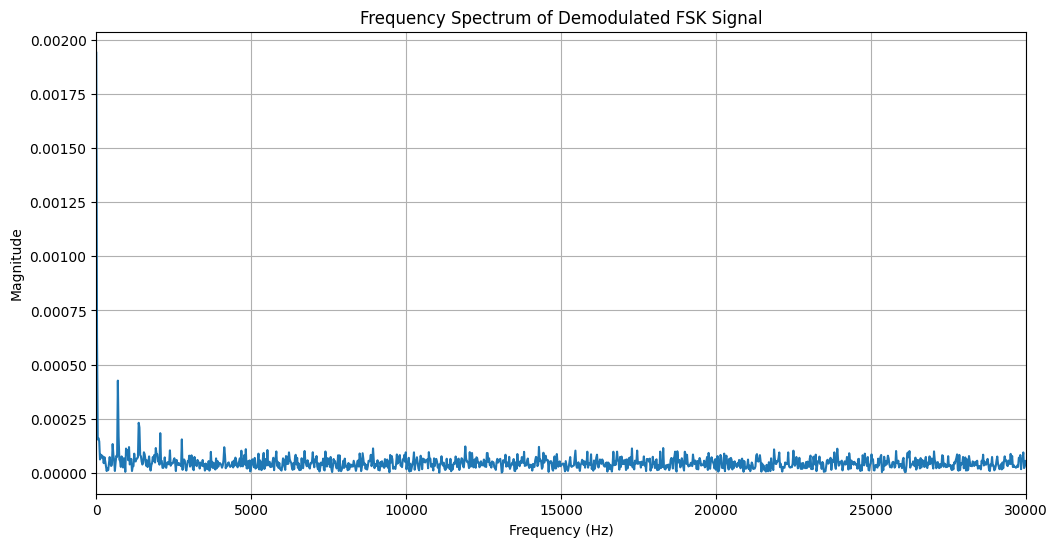

In [172]:


resampled_signal = demodulated_signal[OVERSAMPLING_RATE // 2 :: OVERSAMPLING_RATE]
threshold = np.mean(resampled_signal)
bitstream = (resampled_signal > threshold).astype(int)

In [173]:
num_bits = len(bitstream)
num_bytes = num_bits // 8

# We'll convert the bits to a bytearray
decoded_bytes_list = []
for i in range(num_bytes):
    byte_value = 0
    for j in range(8):
        # MSB first bit order, as is common
        byte_value += bitstream[i * 8 + j] * (2**(7 - j))
    decoded_bytes_list.append(byte_value)

# Convert the list of byte values to a byte string
byte_string = bytes(decoded_bytes_list)
byte_string

b'\xd1\x80\x08\x97\x8aoW\xdc\xa4\xaew\x10\x11N\xf0\xa1\xd8G\xd3\x8aw\x7fuD\x19\x9dj\x91-\xf7\xff}'

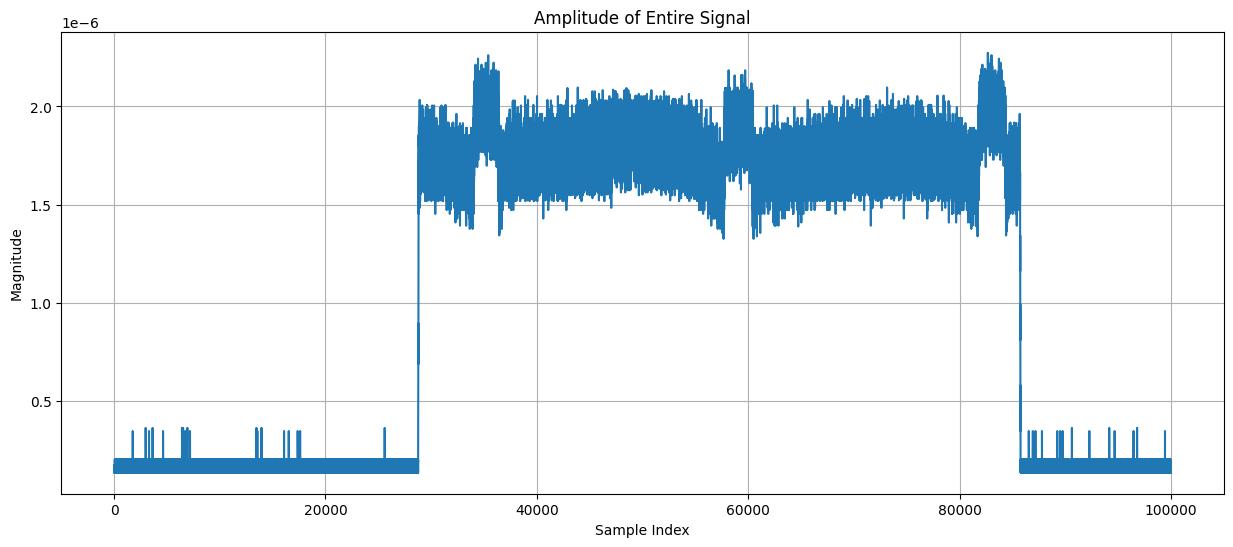

Please use this plot to identify the start_i and len_s values for a signal burst.
The high-amplitude sections of the plot correspond to the transmitted signal.


In [33]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# File path
file_path = './baseband_433123259Hz_12-22-59_30-07-2025.wav'

try:
    # Load the entire WAV file
    sample_rate, data = wavfile.read(file_path)

    # SDR WAV files are often 16-bit signed integers.
    # Convert them to floats in the range [-1.0, 1.0] for processing.
    start_i = 430000
    len_s_i = 100000

    
    I_data = data[:, 0][start_i:start_i + len_s_i] / 32768.0
    Q_data = data[:, 1][start_i:start_i + len_s_i] / 32768.0
    
    # Combine the I and Q channels into a single complex signal
    complex_signal = I_data + 1j * Q_data

    # Calculate the amplitude of the signal

    amplitude = np.abs(complex_signal)

    # Plot the amplitude of the entire signal to find the bursts
    plt.figure(figsize=(15, 6))
    plt.plot(amplitude)
    plt.title('Amplitude of Entire Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

    print("Please use this plot to identify the start_i and len_s values for a signal burst.")
    print("The high-amplitude sections of the plot correspond to the transmitted signal.")

except Exception as e:
    print(f"An error occurred: {e}")


Amplitude of the sliced signal: Mean = 0.0000, Max = 0.0000

Plotting the frequency spectrum of the raw complex signal...


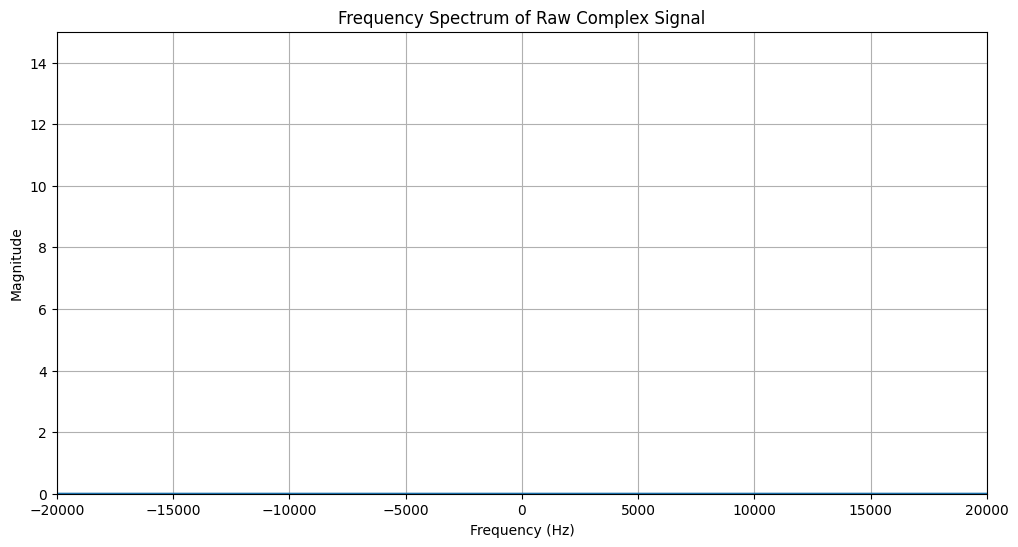


Plotting the frequency spectrum of the demodulated signal...


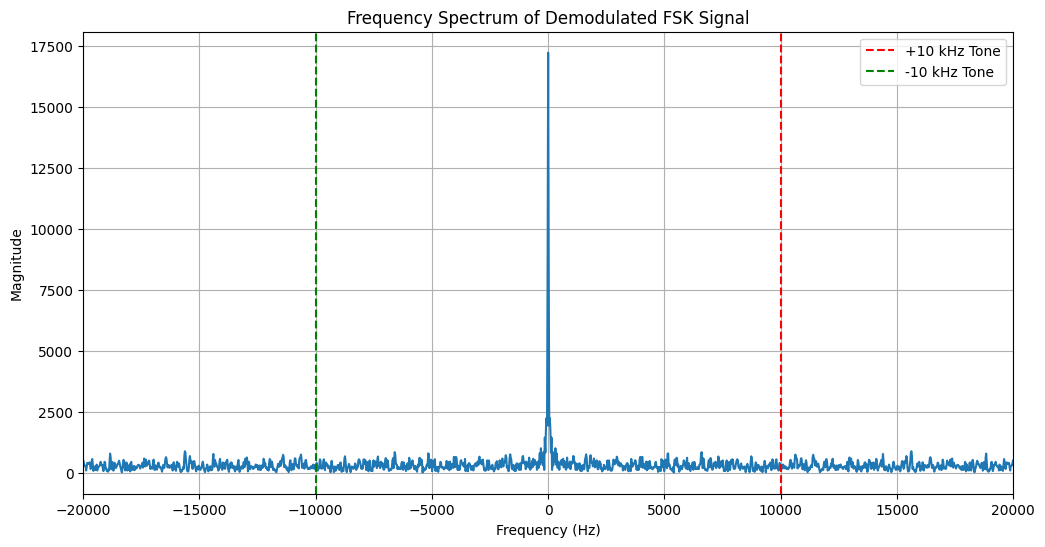

Plotting the bit extraction process...


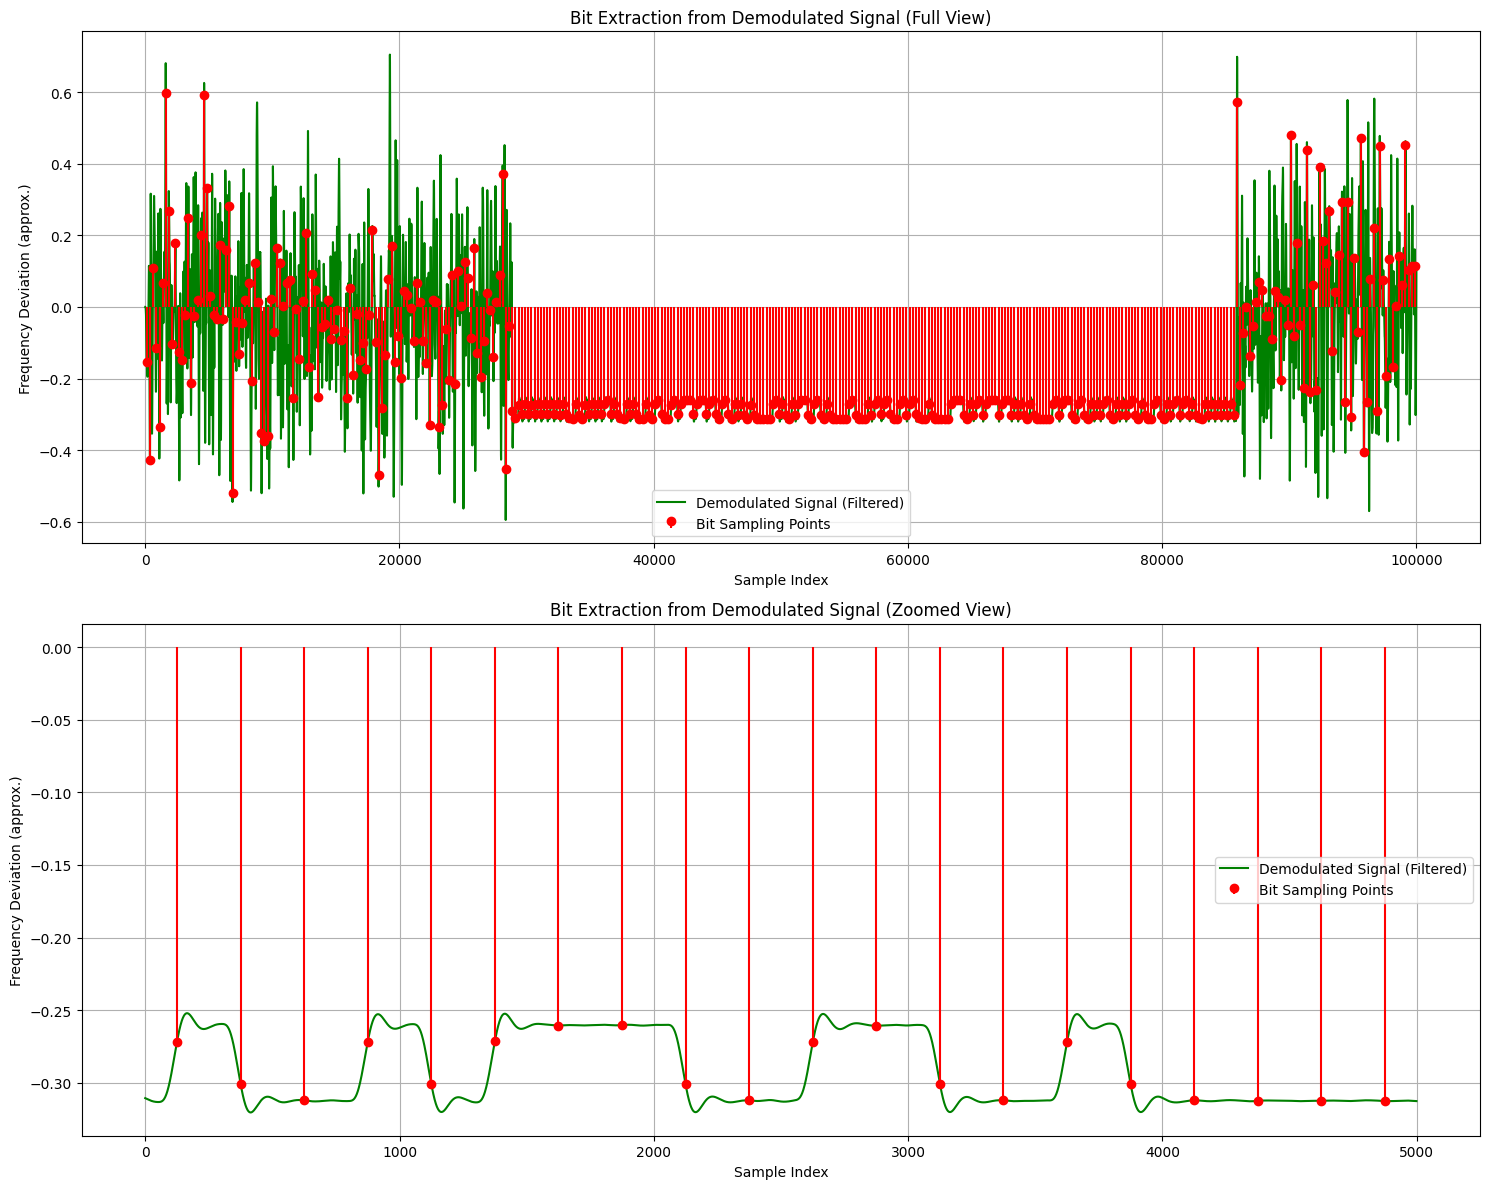

b'\xff\xef\xf1\xff\xff\xff\xff\x9f\xff\xb3\xff\xff\xa0\x00\x00\x00@\x00Bs"\x00\x02\x03\x10\x02\x02B@\x03\x82s\x00\x02b\x02\x02\x02\x1bA\x15\xff\xff\xff\xff\xee\xef\xff'

--- Decoded Messages from FSK Sender ---

@
Bs"
B@s
bA

Raw decoded bytes (hex): ff ef f1 ff ff ff ff 9f ff b3 ff ff a0 00 00 00 40 00 42 73 22 00 02 03 10 02 02 42 40 03 82 73 00 02 62 02 02 02 1b 41 15 ff ff ff ff ee ef ff

Look for the messages 'Hello humans', 'Love is all you need', and 'Bye humans' in the output.


In [41]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

def low_pass_filter(data, cutoff, fs, order=5):
    """
    Applies a low-pass Butterworth filter to the data.
    
    Parameters:
    - data: The input signal.
    - cutoff: The cutoff frequency of the filter in Hz.
    - fs: The sample rate of the signal in Hz.
    - order: The order of the filter.
    
    Returns:
    - The filtered signal.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

def analyze_demodulated_signal_fft(demodulated_signal, sample_rate):
    """
    Performs an FFT on the demodulated signal and plots the frequency spectrum.
    
    Parameters:
    - demodulated_signal: The phase-difference signal from FSK demodulation.
    - sample_rate: The original sample rate of the SDR capture.
    """
    
    # Calculate the FFT of the demodulated signal
    fft_result = np.fft.fft(demodulated_signal)
    
    # Calculate the frequency axis for the plot
    n = len(demodulated_signal)
    fft_freqs = np.fft.fftfreq(n, d=1/sample_rate)

    # Shift the zero-frequency component to the center of the spectrum
    fft_shifted = np.fft.fftshift(fft_result)
    fft_shifted_freqs = np.fft.fftshift(fft_freqs)
    
    plt.figure(figsize=(12, 6))
    plt.plot(fft_shifted_freqs, np.abs(fft_shifted))
    plt.title('Frequency Spectrum of Demodulated FSK Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    
    # Set the x-axis limits to clearly show the FSK tones around 10 kHz
    plt.xlim(-20000, 20000)

    # Add vertical lines at the expected tone frequencies from the Arduino code
    # The tones should be symmetric around 0 Hz.
    plt.axvline(x=10000, color='r', linestyle='--', label='+10 kHz Tone')
    plt.axvline(x=-10000, color='g', linestyle='--', label='-10 kHz Tone')
    plt.legend()
    
    plt.show()

def plot_bit_extraction(resampled_signal, oversampling_rate, filtered_signal):
    """
    Plots the demodulated signal and overlays the resampled signal to visualize bit extraction.
    
    Parameters:
    - resampled_signal: The signal after resampling (one sample per symbol).
    - oversampling_rate: The number of samples per symbol.
    - filtered_signal: The filtered version of the demodulated signal.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=False)
    
    # Full view subplot
    ax1.plot(filtered_signal, 'g', label='Demodulated Signal (Filtered)')
    
    time_points = np.arange(0, len(resampled_signal)) * oversampling_rate + oversampling_rate // 2
    ax1.stem(time_points, resampled_signal, 'r', basefmt=' ', label='Bit Sampling Points')
    
    ax1.set_title('Bit Extraction from Demodulated Signal (Full View)')
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Frequency Deviation (approx.)')
    ax1.grid(True)
    ax1.legend()
    
    # Zoomed view subplot
    zoom_start = 50000
    zoom_end = 55000
    
    ax2.plot(filtered_signal[zoom_start:zoom_end], 'g', label='Demodulated Signal (Filtered)')
    
    time_points_zoom = time_points[
        (time_points >= zoom_start) & (time_points < zoom_end)
    ] - zoom_start
    resampled_signal_zoom = resampled_signal[
        (time_points >= zoom_start) & (time_points < zoom_end)
    ]
    
    ax2.stem(time_points_zoom, resampled_signal_zoom, 'r', basefmt=' ', label='Bit Sampling Points')
    
    ax2.set_title('Bit Extraction from Demodulated Signal (Zoomed View)')
    ax2.set_xlabel('Sample Index')
    ax2.set_ylabel('Frequency Deviation (approx.)')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def decode_fsk_from_wav(file_path):
    """
    Decodes an FSK-modulated signal from a WAV file.

    Parameters:
    - file_path: The path to the WAV file.
    
    Returns:
    - A string containing the decoded message, or a message indicating failure.
    """
    
    # FSK parameters from the Arduino code
    # This is the most crucial part for accurate decoding.
    SAMPLE_RATE = 2400000  # From your WAV file info (2.4 MHz)
    SYMBOL_RATE = 9600     # From the Arduino code (9.6 kbps)
    OVERSAMPLING_RATE = int(SAMPLE_RATE / SYMBOL_RATE) # Calculate the oversampling rate

    # Slicing parameters from your analysis
    # Adjust these values to isolate a strong signal burst from the amplitude plot.
    start_i = 430000
    len_s = 100000

    try:
        # Load the entire WAV file
        sample_rate, data = wavfile.read(file_path)
        
        # Verify the sample rate
        if sample_rate != SAMPLE_RATE:
            print(f"Warning: Expected sample rate {SAMPLE_RATE}, but found {sample_rate}.")
            print("Decoding may fail due to mismatched rates.")

        # SDR WAV files are often 16-bit signed integers.
        # Convert them to floats in the range [-1.0, 1.0] for processing.
        # The number 32768 is 2^15, used to normalize 16-bit signed data.
        I_data = data[:, 0][start_i:start_i + len_s] / 32768.0
        Q_data = data[:, 1][start_i:start_i + len_s] / 32768.0

        # Combine the I and Q channels into a single complex signal
        complex_signal = I_data + 1j * Q_data

        # Print the amplitude of the sliced signal to help with finding the correct slice
        amplitude = np.abs(complex_signal)
        print(f"Amplitude of the sliced signal: Mean = {np.mean(amplitude):.4f}, Max = {np.max(amplitude):.4f}")

        # Plot the frequency spectrum of the raw complex signal to confirm the FSK tones
        print("\nPlotting the frequency spectrum of the raw complex signal...")
        n = len(complex_signal)
        fft_result = np.fft.fft(complex_signal)
        fft_freqs = np.fft.fftfreq(n, d=1/sample_rate)
        fft_shifted = np.fft.fftshift(fft_result)
        fft_shifted_freqs = np.fft.fftshift(fft_freqs)
        
        plt.figure(figsize=(12, 6))
        plt.plot(fft_shifted_freqs, np.abs(fft_shifted))
        plt.title('Frequency Spectrum of Raw Complex Signal')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid(True)
        plt.xlim(-20000, 20000)
        plt.ylim(0, 15)
        plt.show()

        # FSK Demodulation:
        # The frequency of an FSK signal is proportional to the phase change.
        # We find this by taking the difference of the unwrapped phase.
        demodulated_signal = np.diff(np.unwrap(np.angle(complex_signal)))
        
        # Plot the frequency spectrum of the demodulated signal to confirm the FSK tones
        print("\nPlotting the frequency spectrum of the demodulated signal...")
        analyze_demodulated_signal_fft(demodulated_signal, SAMPLE_RATE)

        # Apply a low-pass filter to the demodulated signal to reduce noise.
        # The cutoff frequency should be just above the symbol rate.
        filtered_signal = low_pass_filter(demodulated_signal, cutoff=SYMBOL_RATE * 2, fs=SAMPLE_RATE)
        
        # Resample the signal to get one sample per symbol.
        # This is the most critical step and depends on the oversampling rate.
        resampled_signal = filtered_signal[OVERSAMPLING_RATE // 2 :: OVERSAMPLING_RATE]

        # Use a more robust thresholding method.
        # We find the median of the resampled signal to account for any DC offset or drift.
        threshold = np.median(resampled_signal)
        
        # Plot the bit extraction process to visualize where the bits are sampled
        print("Plotting the bit extraction process...")
        plot_bit_extraction(resampled_signal, OVERSAMPLING_RATE, filtered_signal)
        
        # Convert the resampled signal into a bitstream (0s and 1s)
        bitstream = (resampled_signal > threshold).astype(int)
        
        # --- NEW: More robust preamble detection ---
        # Instead of looking for 16 perfect '1's, we'll allow for a few errors.
        preamble_length = 16
        preamble_index = -1
        # Search for a sequence where the sum of bits is close to the preamble length.
        for i in range(len(bitstream) - preamble_length):
            # Allow for up to 2 bit errors in the preamble
            if np.sum(bitstream[i:i+preamble_length]) >= preamble_length - 2:
                preamble_index = i
                break

        if preamble_index == -1:
            print("Warning: Could not find a clean preamble in the bitstream.")
            # If preamble is not found, we will still try to decode the whole bitstream.
            start_bit_index = 0
        else:
            # We found the preamble. We will start decoding from after the preamble.
            start_bit_index = preamble_index + preamble_length

        # Truncate the bitstream to start from the end of the preamble
        cleaned_bitstream = bitstream[start_bit_index:]

        # Assemble the bits into bytes (8 bits per byte)
        num_bits = len(cleaned_bitstream)
        num_bytes = num_bits // 8
        # We'll convert the bits to a bytearray
        decoded_bytes_list = []
        for i in range(num_bytes):
            byte_value = 0
            for j in range(8):
                # MSB first bit order, as is common
                byte_value += cleaned_bitstream[i * 8 + j] * (2**(7 - j))
            decoded_bytes_list.append(byte_value)
        
        # Convert the list of byte values to a byte string
        byte_string = bytes(decoded_bytes_list)
        print(byte_string)
        # Instead of assuming a fixed packet size, let's split the bytes by the
        # null terminator ('\x00') which is common for C-style strings.
        decoded_packets = byte_string.split(b'\x00')
        
        decoded_strings = []
        for packet_bytes in decoded_packets:
            if len(packet_bytes) > 0:
                try:
                    # Try to decode the non-empty packets as a string
                    packet_string = packet_bytes.decode('ascii', errors='ignore')
                    decoded_strings.append(packet_string)
                except UnicodeDecodeError:
                    decoded_strings.append(f"[Binary data: {packet_bytes.hex()}]")
        
        print("\n--- Decoded Messages from FSK Sender ---")
        for message in decoded_strings:
            print(message.strip())

        # Print the hexadecimal representation of the raw bytes for debugging
        print("\nRaw decoded bytes (hex):", ' '.join(f'{b:02x}' for b in byte_string))

    except Exception as e:
        return f"An error occurred: {e}"

# --- Main execution ---
file_path = './baseband_433123259Hz_12-22-59_30-07-2025.wav'
decode_fsk_from_wav(file_path)

print("\nLook for the messages 'Hello humans', 'Love is all you need', and 'Bye humans' in the output.")


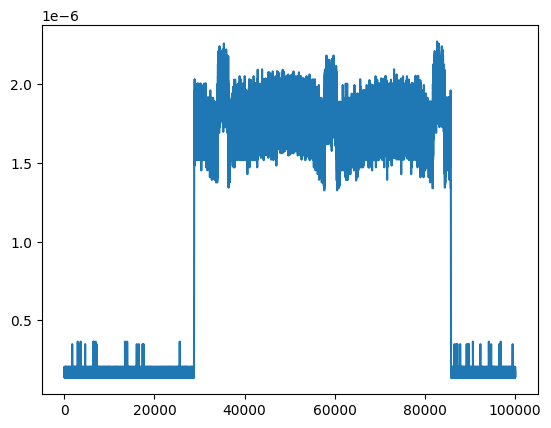

In [40]:
plt.plot(amplitude)